In [4]:
# 📂 Basic Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# ⚙️ ML Libraries
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

# Warnings & Settings
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline


In [9]:
# Example: Load the UCI Email Spam Dataset
# You may upload a CSV or use any available spam dataset
df = pd.read_csv('spam.csv', encoding='latin-1')  # Change path accordingly

# Inspect data
df.head()


,Email No.,the,to,ect,and,for,of,a,you,hou,...,connevey,jay,valued,lay,infrastructure,military,allowing,ff,dry,Prediction
0,Email 1,0,0,1,0,0,0,2,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Email 2,8,13,24,6,6,2,102,1,27,...,0,0,0,0,0,0,0,1,0,0
2,Email 3,0,0,1,0,0,0,8,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Email 4,0,5,22,0,5,1,51,2,10,...,0,0,0,0,0,0,0,0,0,0
4,Email 5,7,6,17,1,5,2,57,0,9,...,0,0,0,0,0,0,0,1,0,0


In [11]:
# Drop unnecessary columns like "Email No."
X = df.drop(columns=['Email No.', 'Prediction'])

# Target variable
y = df['Prediction']

# Check shapes
print(f"Features shape: {X.shape}, Target shape: {y.shape}")


Features shape: (5172, 3000), Target shape: (5172,)


In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


In [13]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [14]:
lr = LogisticRegression()
lr.fit(X_train_scaled, y_train)
lr_pred = lr.predict(X_test_scaled)

print("Logistic Regression:\n", classification_report(y_test, lr_pred))


Logistic Regression:
               precision    recall  f1-score   support

           0       0.99      0.97      0.98       735
           1       0.92      0.97      0.94       300

    accuracy                           0.97      1035
   macro avg       0.95      0.97      0.96      1035
weighted avg       0.97      0.97      0.97      1035



In [18]:
dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train, y_train)  # No scaling for Decision Tree
dt_pred = dt.predict(X_test)

print("Decision Tree:\n", classification_report(y_test, dt_pred))


Decision Tree:
               precision    recall  f1-score   support

           0       0.94      0.95      0.94       735
           1       0.87      0.85      0.86       300

    accuracy                           0.92      1035
   macro avg       0.90      0.90      0.90      1035
weighted avg       0.92      0.92      0.92      1035



In [19]:
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test)

print("Random Forest:\n", classification_report(y_test, rf_pred))


Random Forest:
               precision    recall  f1-score   support

           0       0.98      0.97      0.97       735
           1       0.93      0.94      0.94       300

    accuracy                           0.96      1035
   macro avg       0.96      0.96      0.96      1035
weighted avg       0.96      0.96      0.96      1035



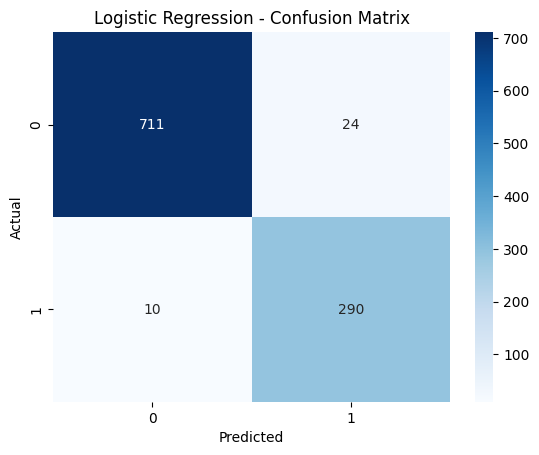

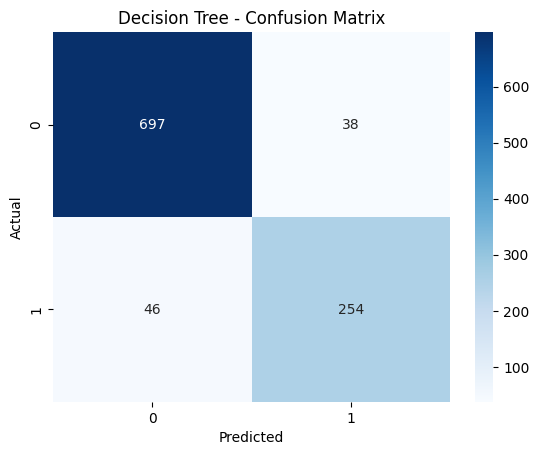

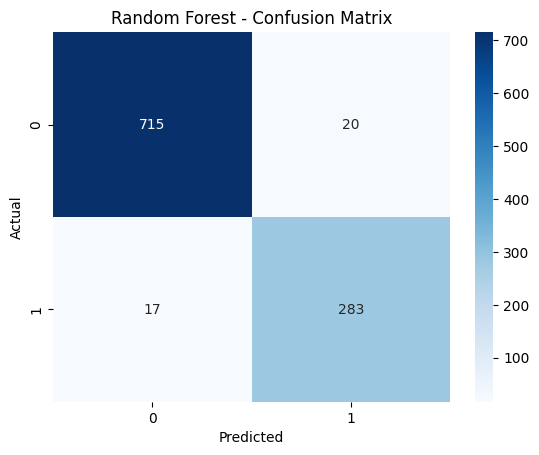

In [20]:
def plot_conf_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f"{title} - Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

plot_conf_matrix(y_test, lr_pred, "Logistic Regression")
plot_conf_matrix(y_test, dt_pred, "Decision Tree")
plot_conf_matrix(y_test, rf_pred, "Random Forest")


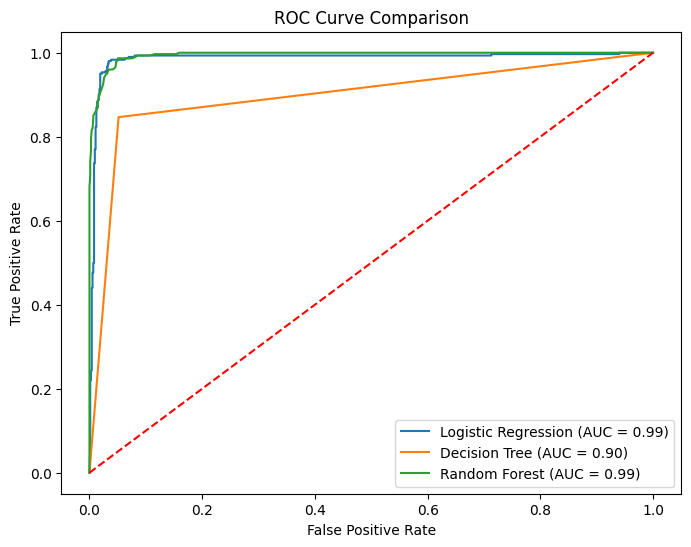

In [21]:
plt.figure(figsize=(8, 6))

models = {'Logistic Regression': lr, 'Decision Tree': dt, 'Random Forest': rf}

for name, model in models.items():
    # DecisionTree doesn't have predict_proba sometimes, so add check
    y_score = model.predict_proba(X_test_scaled if name == 'Logistic Regression' else X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_score)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'r--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend()
plt.show()


In [22]:
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10]
}

grid = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=3, scoring='accuracy', verbose=1)
grid.fit(X_train, y_train)

print("Best Parameters:", grid.best_params_)

best_rf = grid.best_estimator_
best_pred = best_rf.predict(X_test)

print("Tuned Random Forest:\n", classification_report(y_test, best_pred))


Fitting 3 folds for each of 27 candidates, totalling 81 fits
Best Parameters: {'max_depth': None, 'min_samples_split': 5, 'n_estimators': 200}
Tuned Random Forest:
               precision    recall  f1-score   support

           0       0.98      0.97      0.98       735
           1       0.94      0.96      0.95       300

    accuracy                           0.97      1035
   macro avg       0.96      0.97      0.96      1035
weighted avg       0.97      0.97      0.97      1035



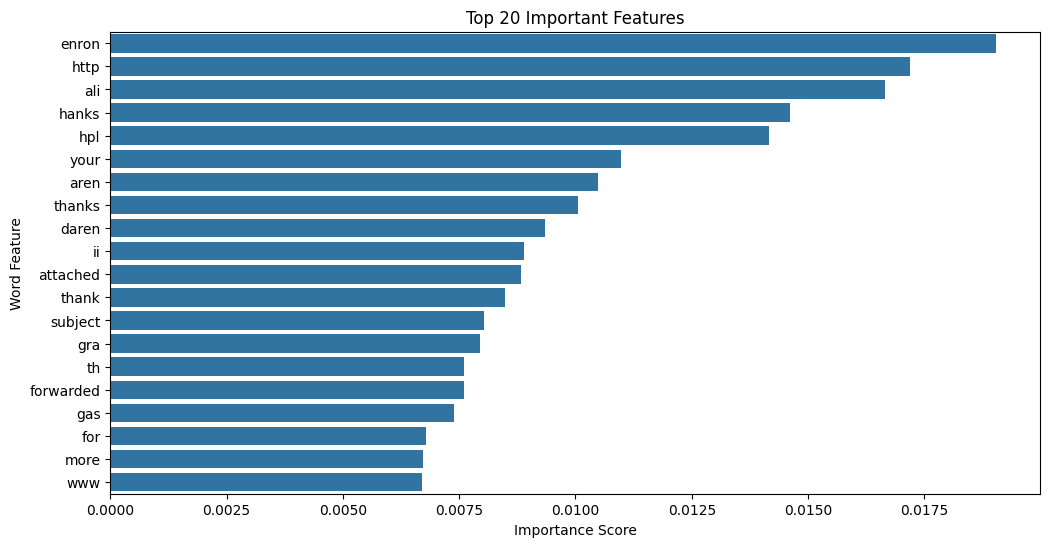

In [23]:
importances = best_rf.feature_importances_
indices = np.argsort(importances)[::-1]
features = X.columns

plt.figure(figsize=(12, 6))
sns.barplot(x=importances[indices][:20], y=features[indices][:20])
plt.title("Top 20 Important Features")
plt.xlabel("Importance Score")
plt.ylabel("Word Feature")
plt.show()
